In [50]:
import os
import re
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [17]:
data = []
root = './blogs'
for fil in os.listdir(root):
    try:
        meta = fil.split('.')[1:3]
        content = open(os.path.join(root, fil), "r", encoding='utf-8', errors='ignore').read()
        data.append(meta+[content])
    except:
        print(os.path.join(root, fil))

In [18]:
data = pd.DataFrame(data, columns=['gender', 'age', 'posts'])
data.head()

,gender,age,posts
0,female,37,"<Blog>\n\n<date>31,May,2004</date>\n<post>\n\n..."
1,female,17,"<Blog>\n\n<date>23,November,2002</date>\n<post..."
2,male,23,"<Blog>\n\n<date>19,June,2004</date>\n<post>\n\..."
3,female,25,"<Blog>\n\n\n\n<date>31,May,2004</date>\n<post>..."
4,male,25,"<Blog>\n\n<date>05,July,2003</date>\n<post>\n\..."


In [19]:
data['posts'][0][:40]

'<Blog>\n\n<date>31,May,2004</date>\n<post>\n'

In [20]:
# нормализовать
# я не имею НИ МАЛЕЙШЕГО ПОНЯТИЯ что значит "обратить внимание на тэги" и просто удаляю их к чертям
# не убираю urlLink потому что количество ссылок может играть роль
data['normalized'] = data['posts'].map(lambda x: re.sub('</?[(?:Blog)|(?:post)]+>|<date>[^<]+</date>', '', x))
data['normalized'] = data['normalized'].map(lambda x: re.sub('\s{2,}', ' ', x).strip())

In [21]:
data.head()

,gender,age,posts,normalized
0,female,37,"<Blog>\n\n<date>31,May,2004</date>\n<post>\n\n...","Well, everyone got up and going this morning. ..."
1,female,17,"<Blog>\n\n<date>23,November,2002</date>\n<post...","Yeah, sorry for not writing for a whole there,..."
2,male,23,"<Blog>\n\n<date>19,June,2004</date>\n<post>\n\...","cupid,please hear my cry, cupid, please let yo..."
3,female,25,"<Blog>\n\n\n\n<date>31,May,2004</date>\n<post>...",and did i mention that i no longer have to dea...
4,male,25,"<Blog>\n\n<date>05,July,2003</date>\n<post>\n\...",B-Logs: The Business Blogs Paradox urlLink Hin...


In [22]:
# векторизовать
cv = CountVectorizer(preprocessor=WordNetLemmatizer().lemmatize, stop_words='english', min_df=2, max_df=0.95)
cv_matrix = cv.fit_transform(data['normalized'])
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(cv_matrix)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, data['gender'])

например, построить частотные списки и сравнить их (достаточно ли матрицы терм-документ с ненормализованными вхождениями слов?)

In [24]:
# НА*&#!@

Tuning RandomForest with GridSearch

Parameters are:
	n_estimators
	max_depth

Fitting models...
Fitted

Best parameters set:
	max_depth: 7
	n_estimators: 100

Predicting test values...
Results are:
             precision    recall  f1-score   support

     female       0.68      0.78      0.73      2386
       male       0.75      0.64      0.69      2444

avg / total       0.72      0.71      0.71      4830

Confusion matrix:
[[1872  514]
 [ 881 1563]]
Parameters and results for training set:


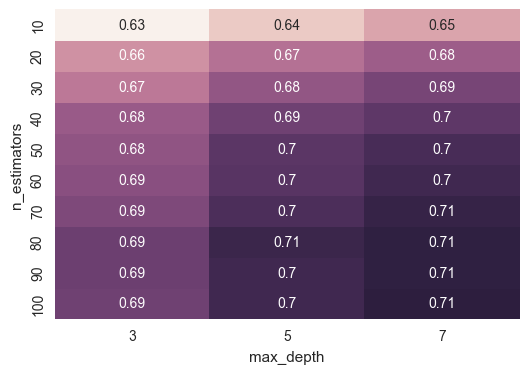

In [48]:
# лес
forest = RandomForestClassifier(random_state=6, n_jobs=-1)
parameters = {'n_estimators': list(range(10, 101, 10)), 'max_depth': [3, 5, 7]} # list(range(1, 10, 2))
print('Tuning RandomForest with GridSearch')
print()
print('Parameters are:\n\t{}'.format('\n\t'.join(list(parameters.keys()))))
print()
sys.stdout.write('Fitting models...')
gs = GridSearchCV(forest, parameters)
gs = gs.fit(X_train, y_train)
sys.stdout.write('Fitted')

# здесь про параметры
print()
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t{}: {}".format(param_name, best_parameters[param_name]))
print()
print('Predicting test values...')
prediction = gs.predict(X_test)
print('Results are:')
print(classification_report(y_test, prediction))
print('Confusion matrix:')
print(confusion_matrix(y_test, prediction))
print()
print('Parameters and results for training set:')
fscs = list(map(lambda x: round(x, 3), gs.cv_results_['mean_test_score']))
params_order = sorted(parameters.keys())
data = []
for fsc, params in zip(fscs, gs.cv_results_['params']):
    data.append([fsc, params[params_order[0]], params[params_order[1]]])
data = pd.DataFrame(data, columns=['mean']+params_order).fillna("None")
data = data.pivot('n_estimators', 'max_depth', 'mean')
sns.heatmap(data, annot=True, cbar=False);

In [52]:
# байес
# тут не то чтобы много можно было настраивать
print('Plain Naive Bayes')
bayes = MultinomialNB()
# parameters = {}
# print('Tuning RandomForest with GridSearch')
# print()
# print('Parameters are:\n\t{}'.format('\n\t'.join(list(parameters.keys()))))
# print()
# print('Fitting models...')
# gs = GridSearchCV(bayes, parameters)
# gs = gs.fit(X_train, y_train)
sys.stdout.write('Fitting model...')
bayes = bayes.fit(X_train, y_train)
sys.stdout.write('Fitted\n')
# здесь про параметры
print('Predicting test values...')
# prediction = gs.predict(X_test)
prediction = bayes.predict(X_test)
print('Results are:')
print(classification_report(y_test, prediction))
print('Confusion matrix:')
print(confusion_matrix(y_test, prediction))

Plain Naive Bayes
Fitting model...Fitted
Predicting test values...
Results are:
             precision    recall  f1-score   support

     female       0.67      0.84      0.75      2386
       male       0.80      0.60      0.68      2444

avg / total       0.73      0.72      0.71      4830

Confusion matrix:
[[2012  374]
 [ 985 1459]]


Tuning multinomial LogisticRegression with GridSearch

Parameters:
	multi_class
	solver

Fitting models...done

Best parameters set:
	multi_class: multinomial
	solver: lbfgs

Predicting test values...done

Results:
             precision    recall  f1-score   support

     female       0.82      0.82      0.82      2386
       male       0.82      0.82      0.82      2444

avg / total       0.82      0.82      0.82      4830

Confusion matrix:
[[1949  437]
 [ 434 2010]]

Parameters and results:


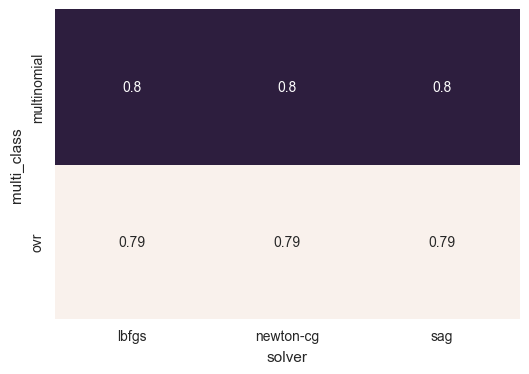

In [59]:
# логрег
# lgrg = LogisticRegression(random_state=4, n_jobs=-1)
parameters_lgrg = {'multi_class': ['ovr', 'multinomial'], 'solver': ['lbfgs', 'sag', 'newton-cg']}
print('Tuning multinomial LogisticRegression with GridSearch')
print()
print('Parameters:\n\t{}'.format('\n\t'.join(list(parameters_lgrg.keys()))))
print()
sys.stdout.write('Fitting models...')
# gs_lgrg = GridSearchCV(lgrg, params)
# gs_lgrg = gs_lgrg.fit(X_train, y_train)
print('done')

# здесь про параметры

print()

print("Best parameters set:")
best_parameters = gs_lgrg.best_estimator_.get_params()
for param_name in sorted(parameters_lgrg.keys()):
    print("\t{}: {}".format(param_name, best_parameters[param_name]))
print()


sys.stdout.write('Predicting test values...')
prediction = gs_lgrg.predict(X_test)
print('done')
print()
print('Results:')
print(classification_report(y_test, prediction))
print('Confusion matrix:')
print(confusion_matrix(y_test, prediction))
print()


# heatmap
print('Parameters and results:')
fscs = list(map(lambda x: round(x, 3), gs_lgrg.cv_results_['mean_test_score']))
params_order = sorted(parameters_lgrg.keys())
data = []
for fsc, params in zip(fscs, gs_lgrg.cv_results_['params']):
    data.append([fsc, params[params_order[0]], params[params_order[1]]])
data = pd.DataFrame(data, columns=['mean']+params_order).fillna("None")
data = data.pivot('multi_class', 'solver', 'mean')
sns.heatmap(data, annot=True, cbar=False);

Вообще-то у нас класс бинарный и multinomial не нужен, это просто на посмотреть. Я не знаю, что делает C, но можно попробовать

Tuning binary LogisticRegression with GridSearch

Parameters:
	C

Fitting models...done

Best parameters set:
	C: 2.5

Predicting test values...done

Results:
             precision    recall  f1-score   support

     female       0.82      0.82      0.82      2386
       male       0.82      0.82      0.82      2444

avg / total       0.82      0.82      0.82      4830

Confusion matrix:
[[1949  437]
 [ 430 2014]]

Parameters and results:


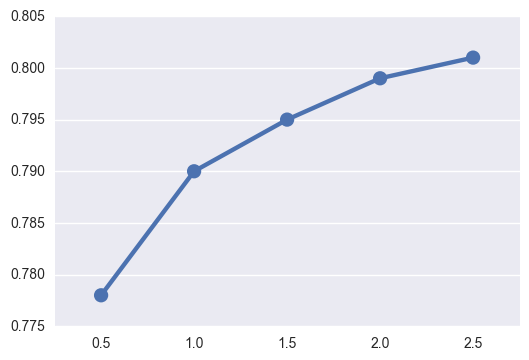

In [73]:
# логрег
lgrg0 = LogisticRegression(random_state=4, n_jobs=-1)
parameters_lgrg0 = {'C': [0.5, 1.0, 1.5, 2.0, 2.5]}
print('Tuning binary LogisticRegression with GridSearch')
print()
print('Parameters:\n\t{}'.format('\n\t'.join(list(parameters_lgrg0.keys()))))
print()
sys.stdout.write('Fitting models...')
gs_lgrg0 = GridSearchCV(lgrg0, parameters_lgrg0)
gs_lgrg0 = gs_lgrg0.fit(X_train, y_train)
print('done')

# здесь про параметры

print()

print("Best parameters set:")
best_parameters = gs_lgrg0.best_estimator_.get_params()
for param_name in sorted(parameters_lgrg0.keys()):
    print("\t{}: {}".format(param_name, best_parameters[param_name]))
print()


sys.stdout.write('Predicting test values...')
prediction = gs_lgrg0.predict(X_test)
print('done')
print()
print('Results:')
print(classification_report(y_test, prediction))
print('Confusion matrix:')
print(confusion_matrix(y_test, prediction))
print()

# learning curve
print('Parameters and results:')
fscs_lgrg0 = list(map(lambda x: round(x, 3), gs_lgrg0.cv_results_['mean_test_score']))
sns.pointplot(parameters_lgrg0['C'], fscs_lgrg0);